In [173]:
import csv
import numpy as np
import pandas as pd

import tensorflow as tf
from keras import backend as K
num_cores = 6

num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

from keras.models import load_model
from sklearn.externals import joblib

# Load model, best weights and scaler
model = load_model('model.h5')
model.load_weights("weights.hdf5")
scaler = joblib.load("scaler.save")

In [174]:
# df = pd.read_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index_col=None)
scaled_data = np.loadtxt('scaled_data.csv', delimiter=';')

In [175]:
# df.tail()
scaled_data[-5:]

array([[3.89726003e-01, 4.03776617e-01, 3.54152307e-01, 3.76411071e-01,
        3.74679195e-01, 3.02713359e-04],
       [3.89726003e-01, 4.03776617e-01, 3.54152307e-01, 3.76411071e-01,
        3.74679195e-01, 6.52498964e-06],
       [3.89857742e-01, 4.03776416e-01, 3.60032050e-01, 3.76410861e-01,
        3.80372063e-01, 1.12422478e-02],
       [3.92055915e-01, 4.03776617e-01, 3.60032050e-01, 3.82130253e-01,
        3.74679195e-01, 2.79746874e-04],
       [3.95318532e-01, 4.09244819e-01, 3.60032050e-01, 3.82130253e-01,
        3.80372063e-01, 1.00593764e-03]])

In [176]:
# df_values = df.values
# timestamps = df_values[:, 0]
# dataset = df_values[:, 1:].astype("float")

In [177]:
# samples_num = df.shape[0]
# test_split = .1
# dataset_test = df[int(samples_num * (1 - test_split)):-17000]
# print(dataset_test.shape)

# Split the dataset into training (70%), cross validation (20%) and test (10%) set
samples_num = scaled_data.shape[0]

valid_split = 0.2
test_split = 0.1

train_full_window = int((samples_num//scaler_window_size) * (1-valid_split-test_split)) * scaler_window_size
valid_full_window = int((samples_num//scaler_window_size) * (valid_split)) * scaler_window_size

dataset_train = scaled_data[0:train_full_window]
dataset_valid = scaled_data[train_full_window:train_full_window+valid_full_window]
dataset_test = scaled_data[train_full_window+valid_full_window:]

print(dataset_test.shape)

(27729, 6)


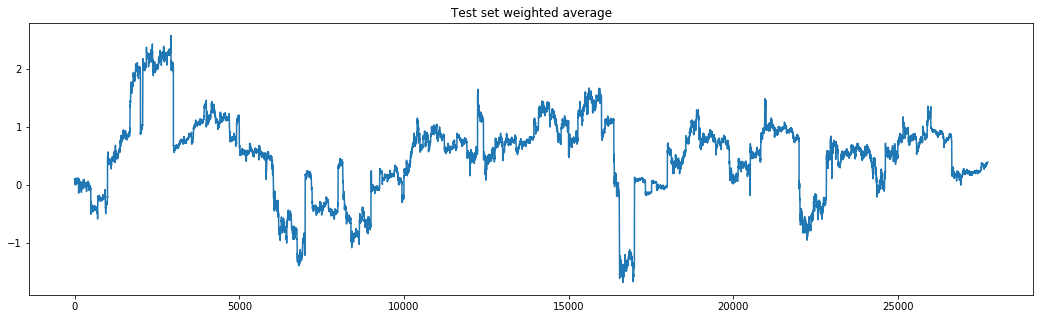

In [178]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Test set weighted average')
# plt.plot(dataset_test[['date']], dataset_test[['weightedAverage']])
plt.plot(dataset_test[:,0])
plt.show()

In [179]:
# data = np.array(dataset_test[['weightedAverage', 'low', 'high', 'open', 'close', 'quoteVolume']])
# data = scaler.transform(data)
# print(data[0])
# print(data.shape)

In [180]:
# plt.figure(figsize=(18, 5))
# plt.title('Weighted average - scaled')
# plt.plot(data[:,0])
# plt.show()

In [181]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(np.array(data))
# data = scaler.transform(data)

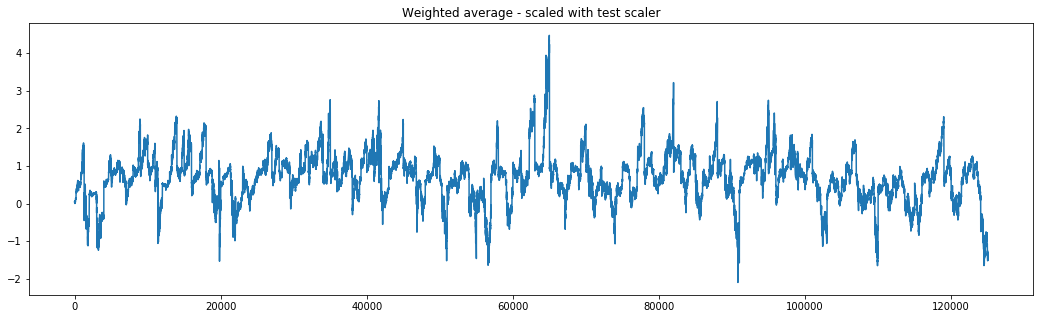

In [182]:
data = dataset_train

plt.figure(figsize=(18, 5))
plt.title('Weighted average - scaled with test scaler')
plt.plot(data[:,0])
plt.show()

In [183]:
import sys

prediction_range = 50
prediction_lookback = 250

predictions = np.zeros(prediction_lookback)

for interval in range((data.shape[0]-prediction_lookback)//prediction_range):
    sys.stdout.write("\r" + str(interval) + "/" + str((data.shape[0]-prediction_lookback)//prediction_range) )
    sys.stdout.flush()
    
    # Prediction from last 'prediction_lookback' candles
    lasts = data[prediction_range*interval:prediction_range*interval+prediction_lookback]

    for candles in range(prediction_range):
        d = lasts[-prediction_lookback:] 
#         print(d.shape)
        d = np.expand_dims(d, axis=0) # NN waits for array, we use just 1 candle as input
        next = model.predict(d, batch_size=1)
        lasts = np.append(lasts, next, axis=0) # Add prediction to known candles
        next = next.reshape(-1,)[0]
        predictions = np.append(predictions, [next], axis=0)
        

123/2495

KeyboardInterrupt: 

In [184]:
print(data.shape)
print(predictions.shape)
print(prediction_lookback,data.shape[0]//prediction_range)

(125000, 6)
(6412,)
250 2500


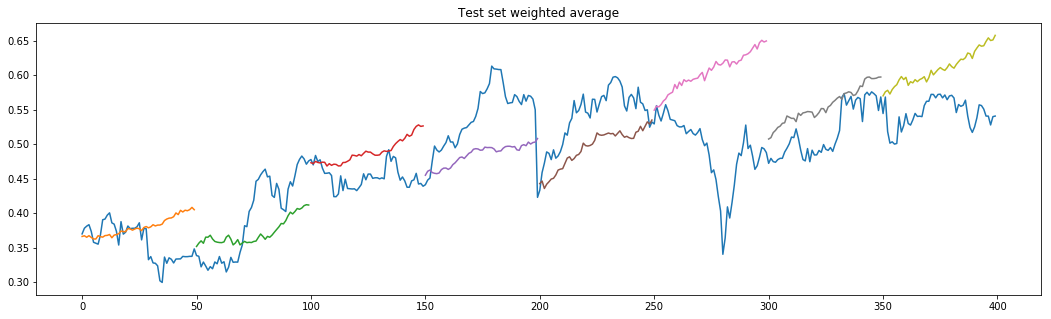

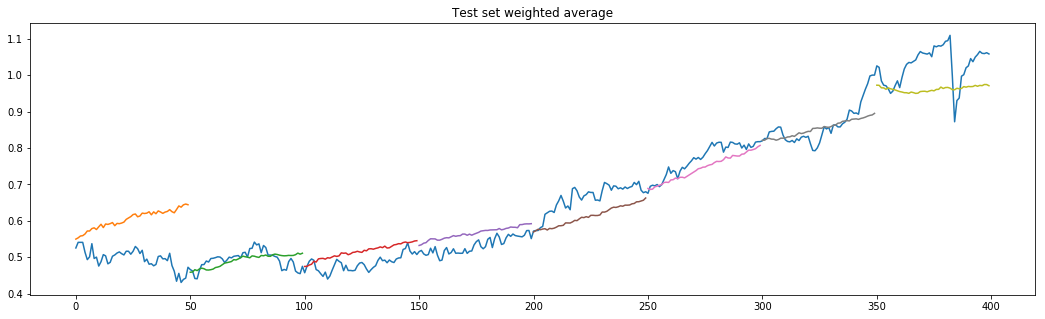

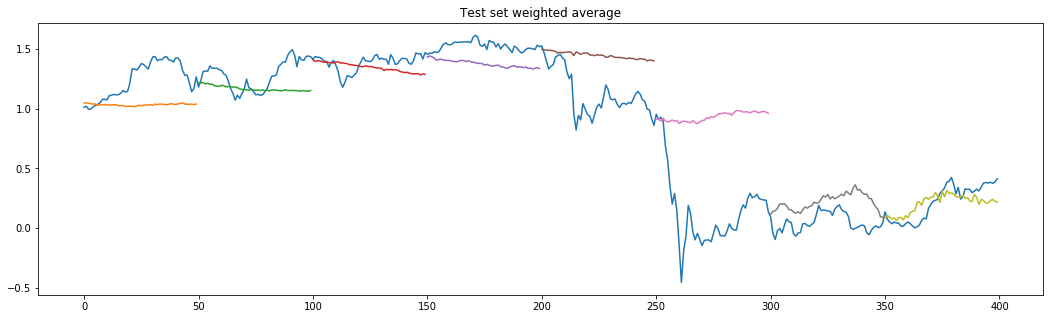

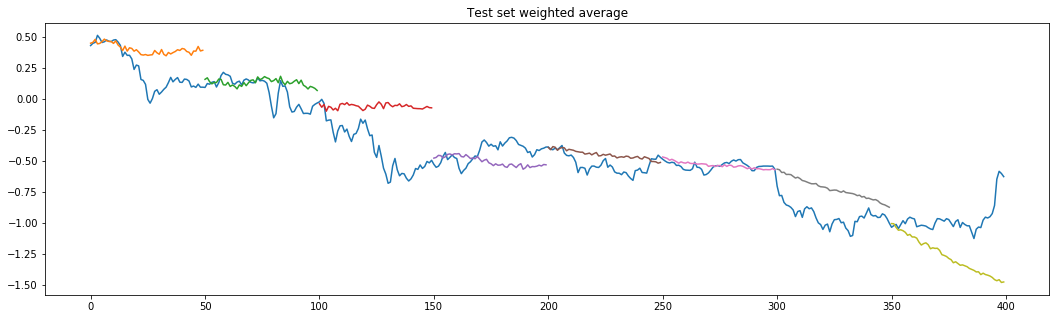

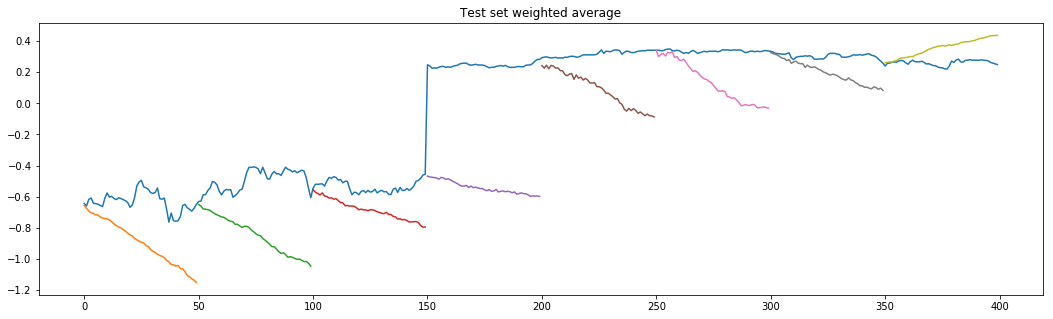

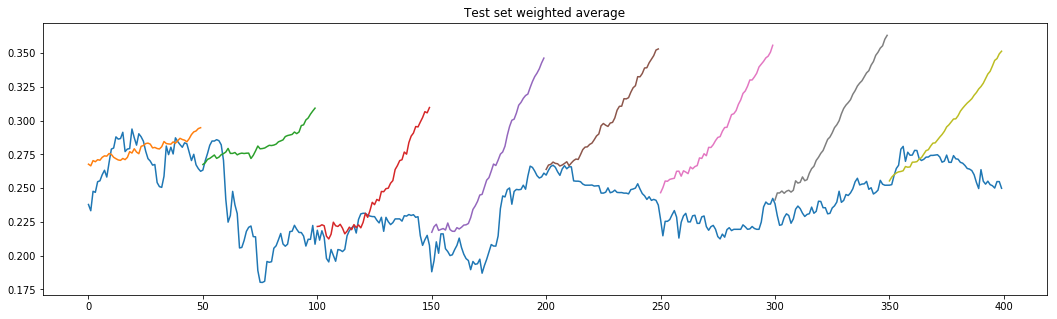

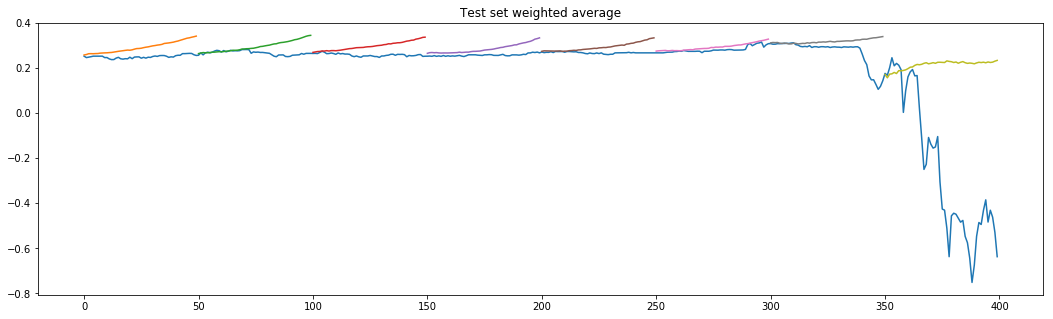

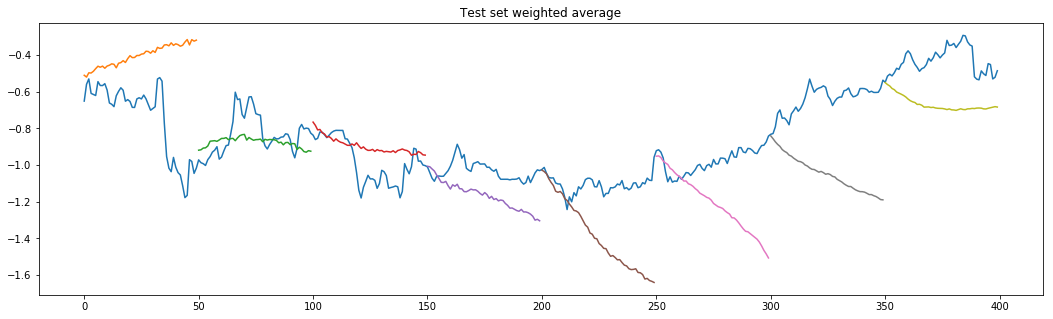

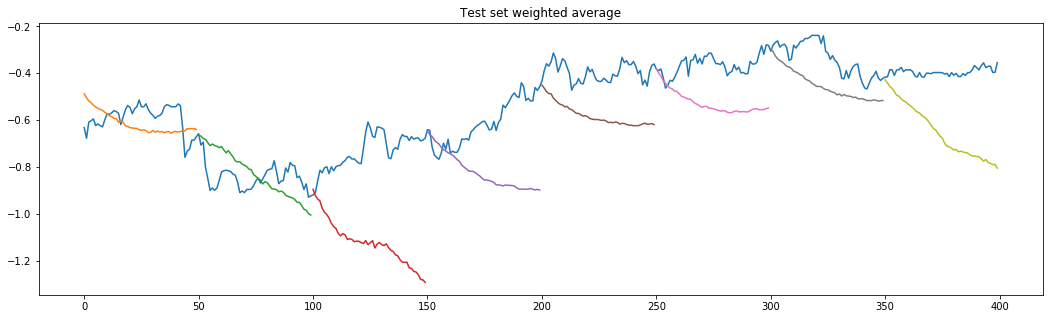

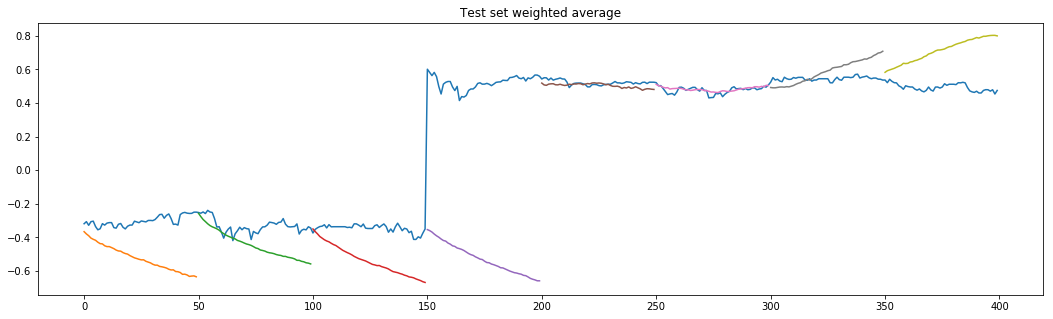

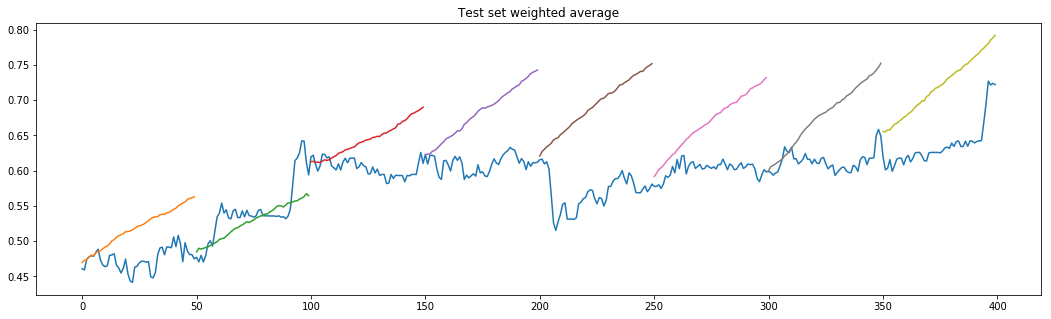

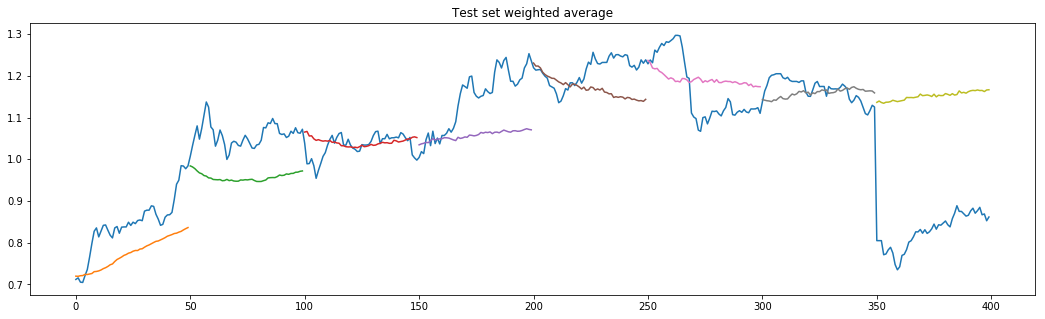

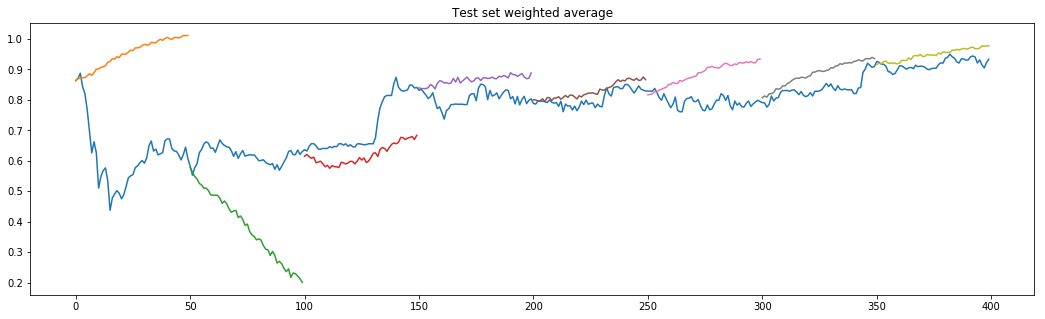

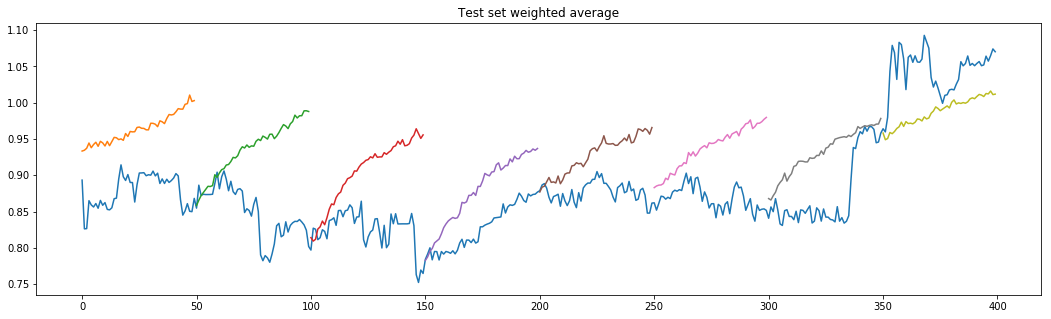

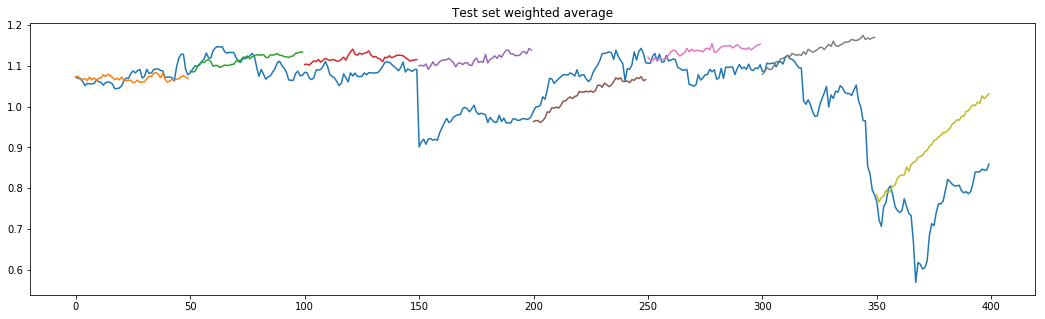

In [185]:
prediction_plot = predictions[prediction_lookback:]
real_plot = data[prediction_lookback:]

plot_length = 400
number_of_plots = prediction_plot.shape[0] // plot_length

for i in range(number_of_plots):
    
    plt.figure(figsize=(18, 5))
    plt.title('Test set weighted average')
    start = i*plot_length
    end = (i+1)*plot_length
    plt.plot(real_plot[start:end, 0])
    for k in range(start, end, prediction_range):
        plt.plot([None for j in range(k-start)] + [x for x in prediction_plot[k:k+prediction_range]])
    plt.show()

# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-500:-200])
# for k in range(-500, -200, prediction_range):
#     plt.plot([None for i in range(k+500)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()

# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-1500:-1300])
# for k in range(-1500, -1300, prediction_range):
#     plt.plot([None for i in range(k+1500)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()


# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-3000:-2800])
# for k in range(-3000, -2800, prediction_range):
#     plt.plot([None for i in range(k+3000)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()